# Employee Promotion Prediction

This project has the goal of predicting whenever an employee should be promoted or not, based on a given dataset. The dataset is composed by arround 50k entries and 13 collumns, 7 of them categorical such as department, region, education, gender and recruitment channel, the avg training score is continuos and the remmaining are discrete, the no of trainings, age, previous years rating, length of service, awards won.


In [517]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as skpp
import imblearn.under_sampling as imbp
import sklearn.neighbors as skkn
import sklearn.metrics as skmt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve
import time
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, auc

## Data Analysis


In [518]:
df = pd.read_csv("employee_promotion_updated.csv")
display(df.head())
print()
display(df.info())
print()
print("Global Promotion Rate: ")
promotion_count = df["is_promoted"].sum()
total_count = len(df)
print(f"Promotion rate: {promotion_count / total_count:.4f}")

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,Bangalore,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,Hyderabad,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,Pune,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,Chennai,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,Mumbai,Bachelor's,m,other,1,45,3.0,2,0,73.0,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55808 entries, 0 to 55807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           55808 non-null  int64  
 1   department            55808 non-null  object 
 2   region                55808 non-null  object 
 3   education             53399 non-null  object 
 4   gender                55808 non-null  object 
 5   recruitment_channel   55808 non-null  object 
 6   no_of_trainings       55808 non-null  int64  
 7   age                   55808 non-null  int64  
 8   previous_year_rating  51684 non-null  float64
 9   length_of_service     55808 non-null  int64  
 10  awards_won            55808 non-null  int64  
 11  avg_training_score    53248 non-null  float64
 12  is_promoted           55808 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 5.5+ MB


None


Global Promotion Rate: 
Promotion rate: 0.0929


In [519]:
print(df.isnull().sum())

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won                 0
avg_training_score      2560
is_promoted                0
dtype: int64


We can see that we have some data missing on education, previous_year_rating and avg_training_score collumns. On this two last collumns it could be the case of a employee that recently joined the company and so we do not have data about the previous year rating and average training score.


In [520]:
print("Previous Year Rating NaN Count by Length of Service: ")
print(df[df["previous_year_rating"].isna()].value_counts(subset=["length_of_service"]))
print()
print("Average Training Score NaN Count by Length of Service: ")
print(df[df["avg_training_score"].isna()].value_counts(subset=["length_of_service"]))

Previous Year Rating NaN Count by Length of Service: 
length_of_service
1                    4124
Name: count, dtype: int64

Average Training Score NaN Count by Length of Service: 
length_of_service
3                    312
2                    304
4                    299
7                    273
5                    271
6                    250
1                    221
9                    131
8                    117
10                    97
11                    46
14                    35
15                    33
12                    30
18                    28
17                    27
13                    25
16                    20
19                    13
20                     6
22                     5
29                     4
21                     3
28                     3
25                     3
26                     1
24                     1
27                     1
31                     1
Name: count, dtype: int64


With that we can conclude that only the previous year rating being null is associated with the fact that the employee has recently joined the company, so we will replace the null values with zero.


In [521]:
df["previous_year_rating"] = df["previous_year_rating"].fillna(0)

Also we are going to analise the balance between promoted and non promoted between the remaining null values to see if this null values are potential important data


In [522]:
print("Previous Year Rating NaN Count by promotion status: ")
print(df[df["avg_training_score"].isna()].value_counts(subset=["is_promoted"]))

promotion_count = df[df["avg_training_score"].isna()]["is_promoted"].sum()
total_count = len(df[df["avg_training_score"].isna()])
print(f"Promotion rate: {promotion_count / total_count:.4f}")

print()

print("Education NaN Count by promotion status: ")
print(df[df["education"].isna()].value_counts(subset=["is_promoted"]))

promotion_count = df[df["education"].isna()]["is_promoted"].sum()
total_count = len(df[df["education"].isna()])
print(f"Promotion rate: {promotion_count / total_count:.4f}")

print()

print("Global Promotion Rate: ")
promotion_count = df["is_promoted"].sum()
total_count = len(df)
print(f"Promotion rate: {promotion_count / total_count:.4f}")

Previous Year Rating NaN Count by promotion status: 
is_promoted
0              2383
1               177
Name: count, dtype: int64
Promotion rate: 0.0691

Education NaN Count by promotion status: 
is_promoted
0              2287
1               122
Name: count, dtype: int64
Promotion rate: 0.0506

Global Promotion Rate: 
Promotion rate: 0.0929


We can see that the promotion rate of the null counts for each of the columns is inferior to the global promotion rate. That means that, since we dont know for sure where the nulls came from, it is safer to delete than any other option since it could affect negatively our analysis.


In [523]:
# drop rows with NaN values in 'avg_training_score' and 'education'
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# We do not need the employee_id column for our analysis
df.drop(columns=["employee_id"], inplace=True)

valueKeyMapping = dict()


def convert_to_numeric(columnName, df):
    unique_values = valueKeyMapping[columnName]
    mapping = {unique_values[i]: i for i in range(len(unique_values))}
    df[columnName] = df[columnName].map(mapping)


def convert_to_string(columnName, df):
    unique_values = valueKeyMapping[columnName]
    mapping = {i: unique_values[i] for i in range(len(unique_values))}
    df[columnName] = df[columnName].map(mapping)


for column in df.columns:
    if df[column].dtype == np.dtype("object"):
        unique_values = df[column].unique()
        valueKeyMapping[column] = unique_values

        convert_to_numeric(column, df)

print("Dataset Description:")
display(df.describe())

# # Interaction features
# df["perf_training"] = df["previous_year_rating"] * df["avg_training_score"]
# df["experience_score"] = df["length_of_service"] * df["avg_training_score"]

# # Ratio features
# df["rating_per_service"] = df["previous_year_rating"] / (df["length_of_service"] + 1)

# # Department-specific features
# dept_promotion_rates = df.groupby("department")["is_promoted"].mean()
# df["dept_promotion_rate"] = df["department"].map(dept_promotion_rates)

Dataset Description:


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
count,50936.000000,50936.000000,50936.00000,50936.000000,50936.000000,50936.000000,50936.000000,50936.000000,50936.000000,50936.000000,50936.000000,50936.000000
mean,2.298414,10.041680,0.76712,0.693792,0.637172,1.321462,35.059859,3.084343,5.996937,0.061940,64.159715,0.095944
std,2.299829,8.640104,0.57420,0.460922,0.649782,0.854490,7.735992,1.486380,4.335316,0.367994,13.542761,0.294517
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,39.000000,0.000000
25%,0.000000,4.000000,0.00000,0.000000,0.000000,1.000000,29.000000,2.000000,3.000000,0.000000,52.000000,0.000000
50%,2.000000,6.000000,1.00000,1.000000,1.000000,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,4.000000,17.000000,1.00000,1.000000,1.000000,1.000000,39.000000,4.000000,8.000000,0.000000,77.000000,0.000000
max,8.000000,33.000000,4.00000,1.000000,5.000000,10.000000,60.000000,5.000000,37.000000,4.000000,99.840000,1.000000


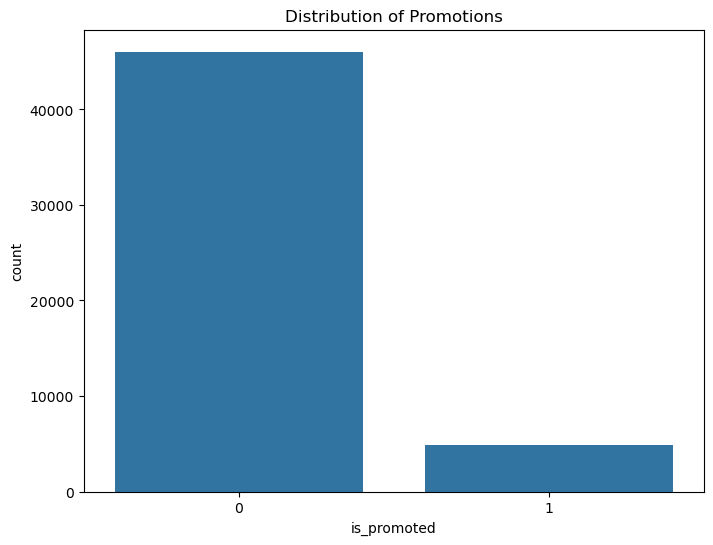

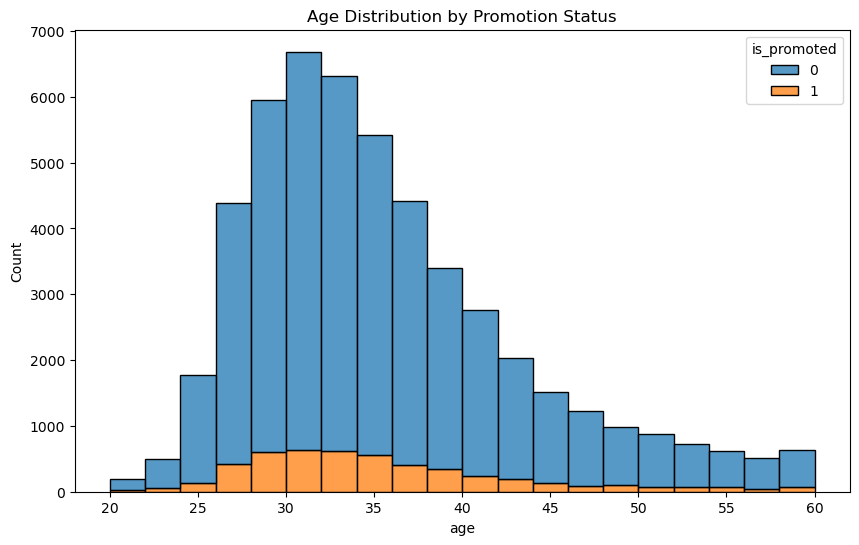

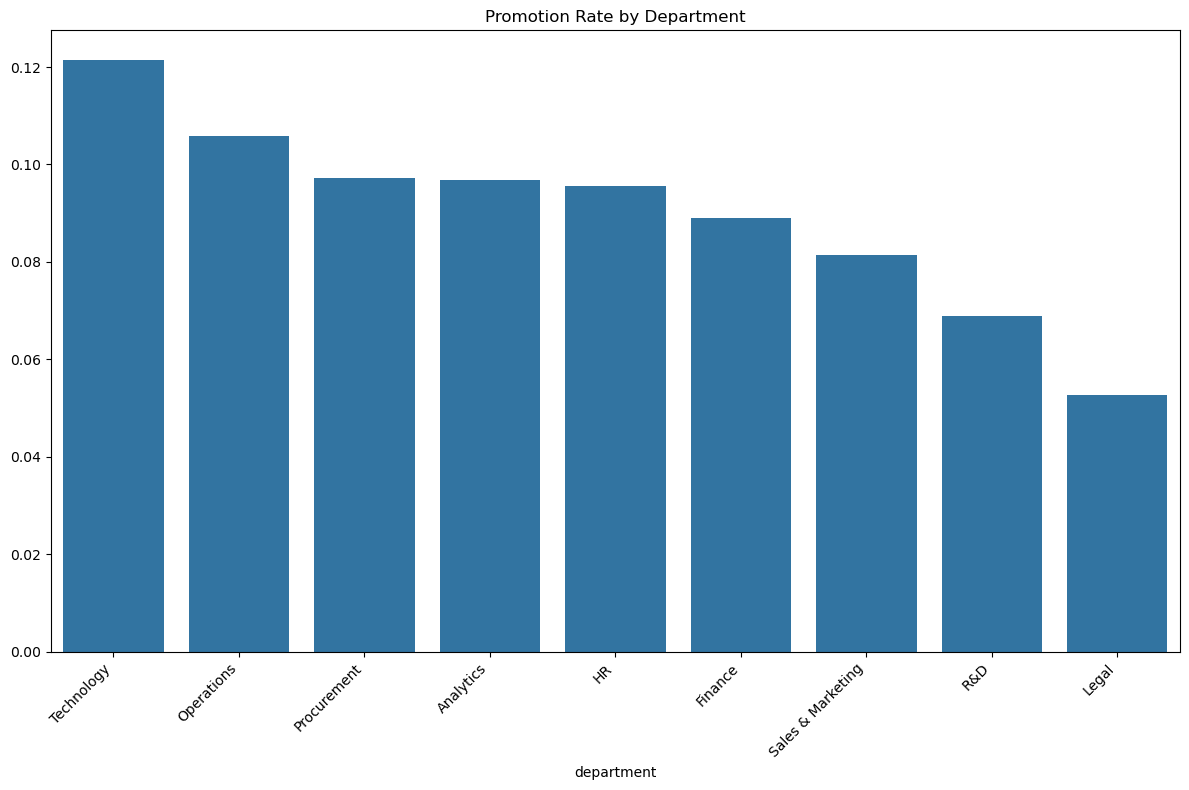

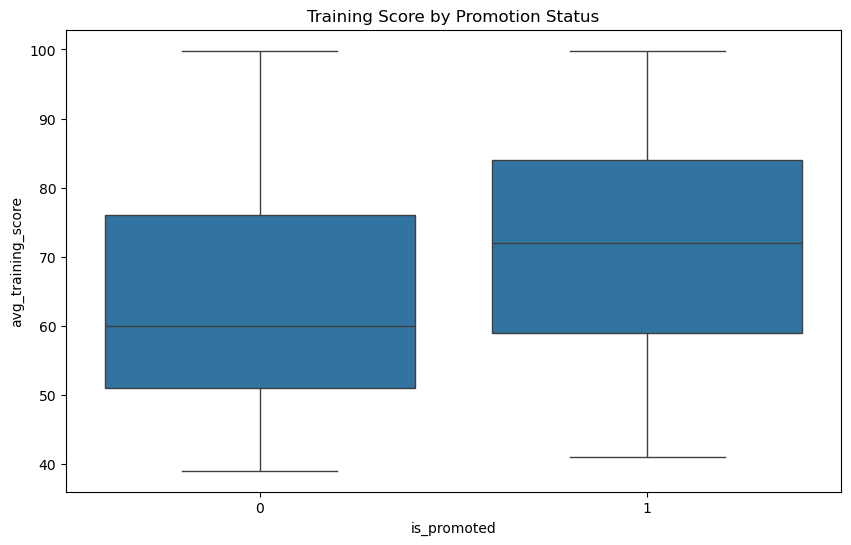

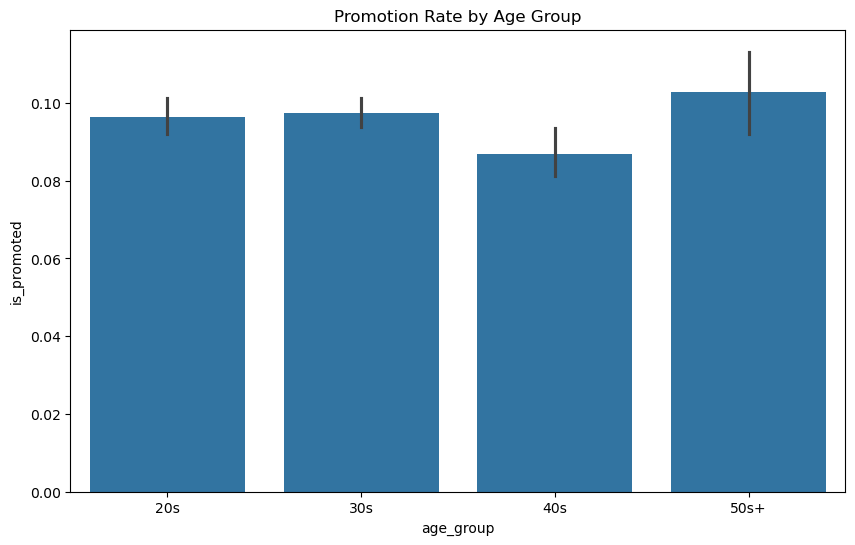

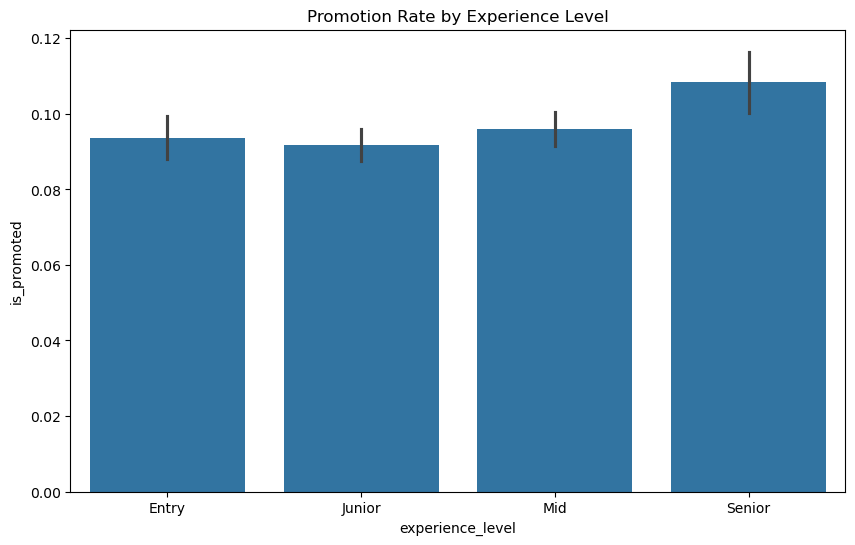

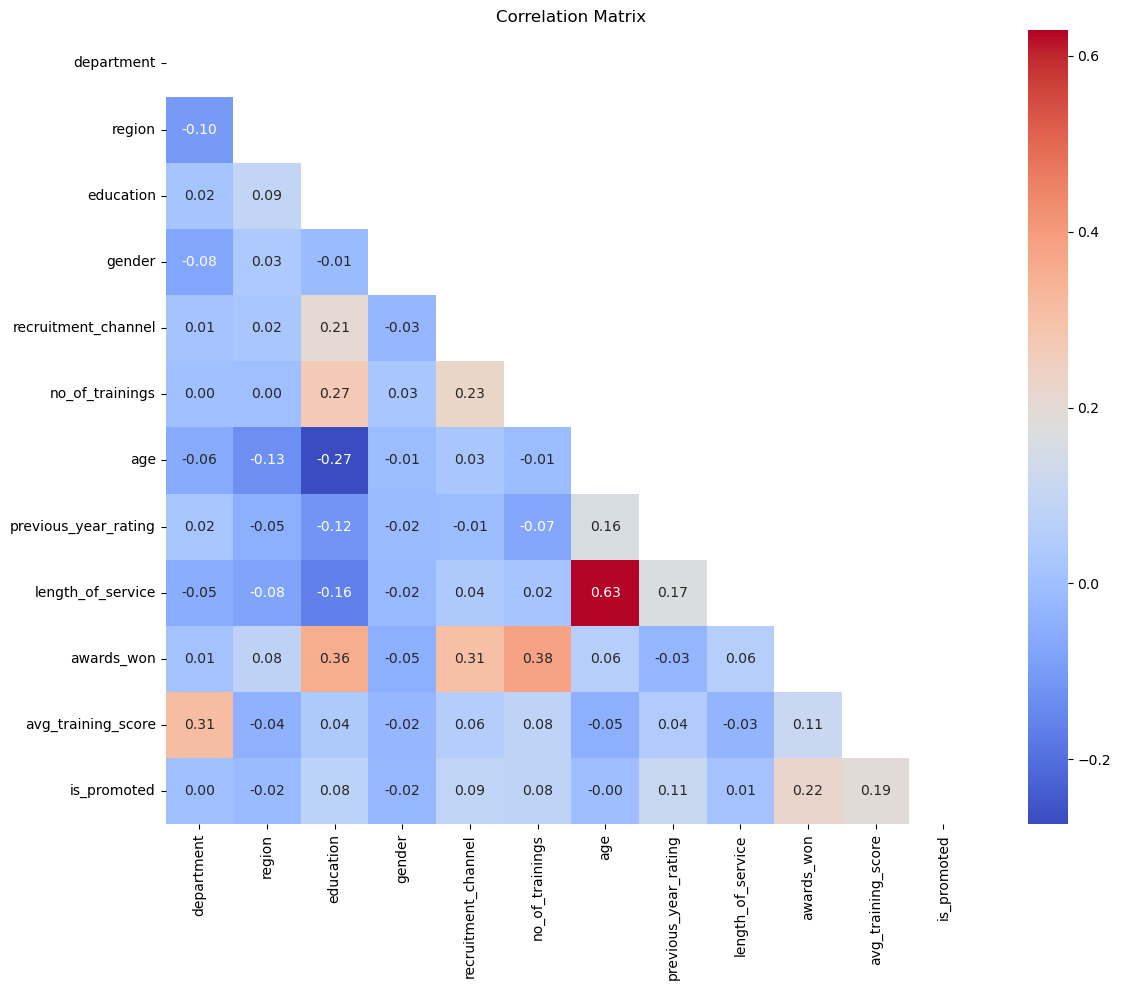

In [524]:
plt.figure(figsize=(8, 6))
sns.countplot(x="is_promoted", data=df)
plt.title("Distribution of Promotions")
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="age", hue="is_promoted", multiple="stack", bins=20)
plt.title("Age Distribution by Promotion Status")
plt.show()


convert_to_string("department", df)
plt.figure(figsize=(12, 8))
dept_promotion = (
    df.groupby("department", observed=True)["is_promoted"]
    .mean()
    .sort_values(ascending=False)
)
sns.barplot(x=dept_promotion.index, y=dept_promotion.values)
plt.title("Promotion Rate by Department")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

convert_to_numeric("department", df)


plt.figure(figsize=(10, 6))
sns.boxplot(x="is_promoted", y="avg_training_score", data=df)
plt.title("Training Score by Promotion Status")
plt.show()

df_copy = df.copy()
df_copy["age_group"] = pd.cut(
    df["age"], bins=[20, 30, 40, 50, 60], labels=["20s", "30s", "40s", "50s+"]
)


df_copy["experience_level"] = pd.cut(
    df["length_of_service"],
    bins=[0, 2, 5, 10, 30],
    labels=["Entry", "Junior", "Mid", "Senior"],
)


plt.figure(figsize=(10, 6))
sns.barplot(x="age_group", y="is_promoted", data=df_copy)
plt.title("Promotion Rate by Age Group")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="experience_level", y="is_promoted", data=df_copy)
plt.title("Promotion Rate by Experience Level")
plt.show()


plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

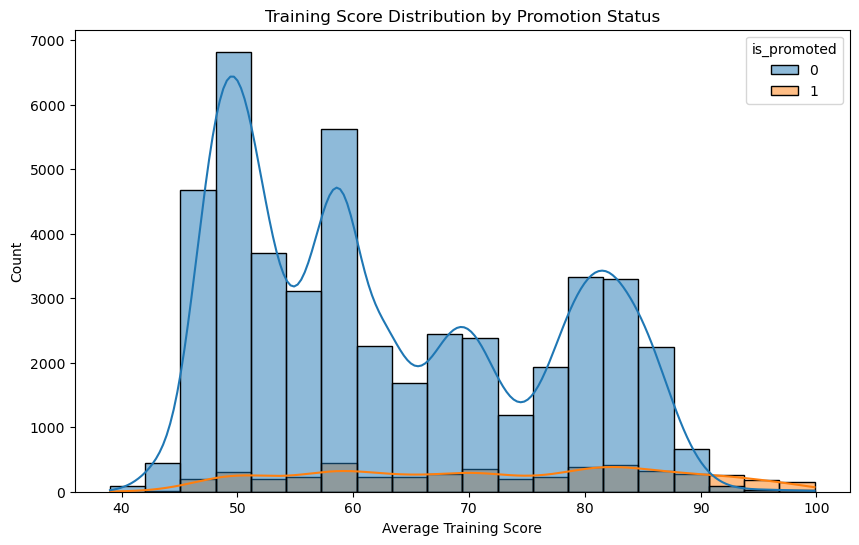

/tmp/ipykernel_83992/534813339.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promotion_by_score = df_copy.groupby("training_score_bin")["is_promoted"].mean() * 100


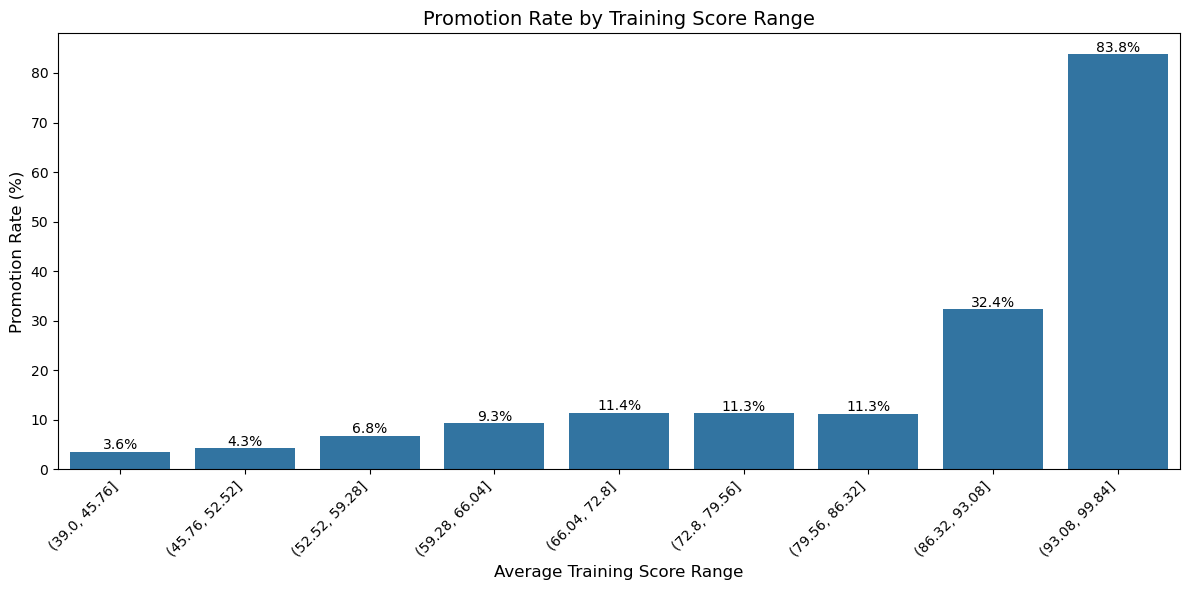

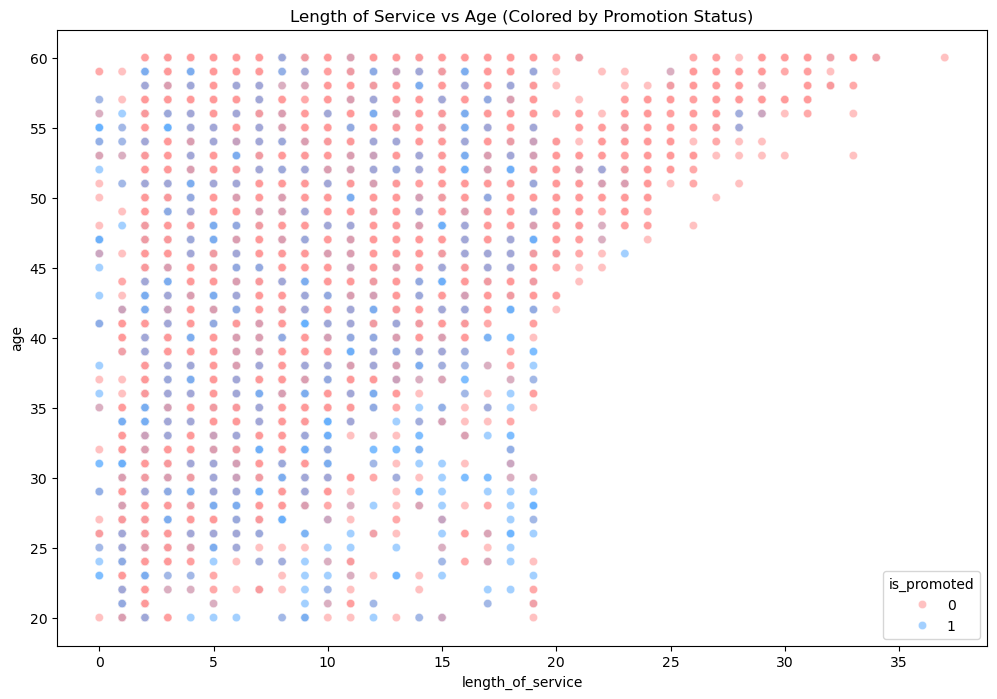

/tmp/ipykernel_83992/534813339.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  previous_year_rating = df_copy.groupby("previous_year_rating")["is_promoted"].mean()


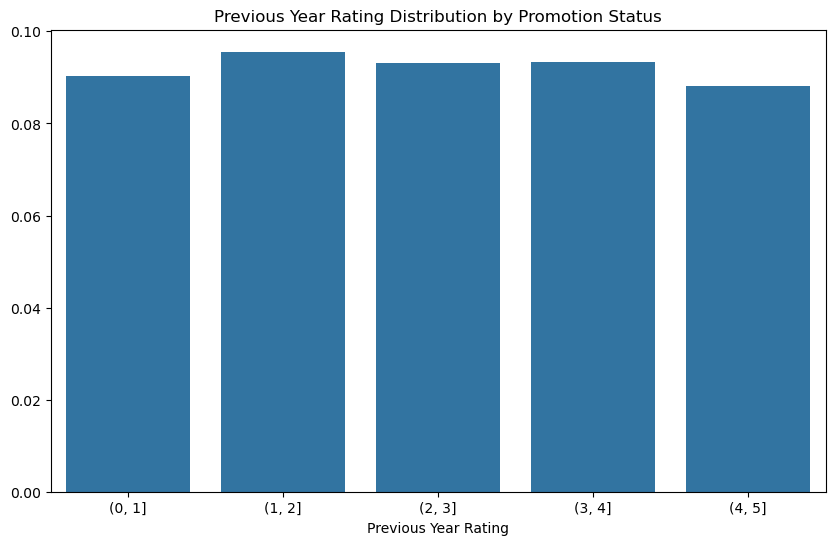

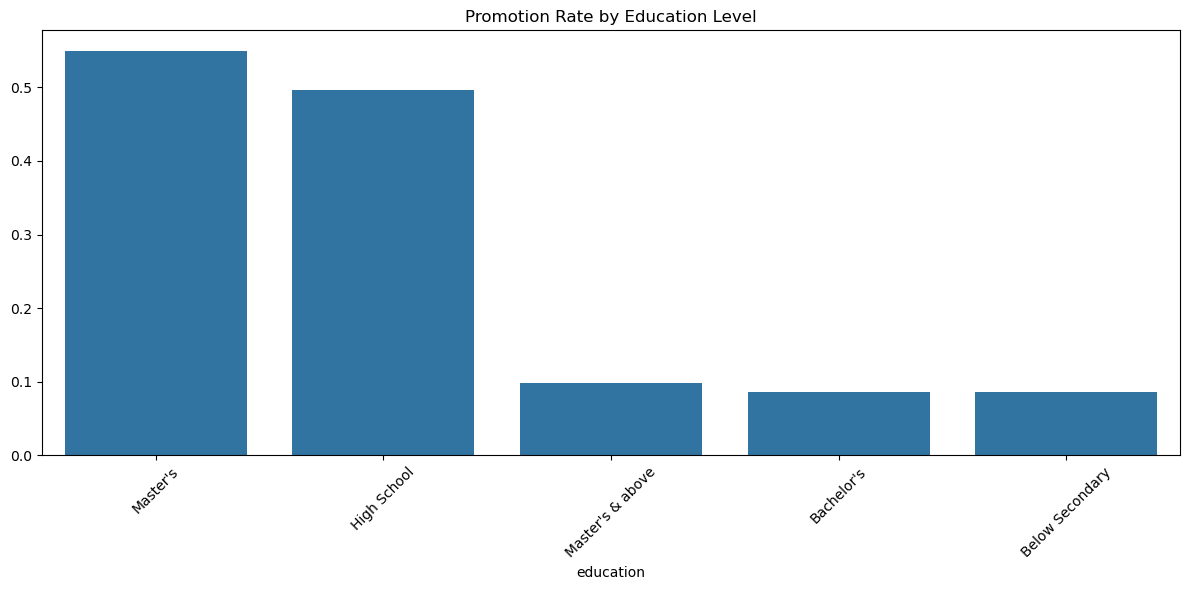

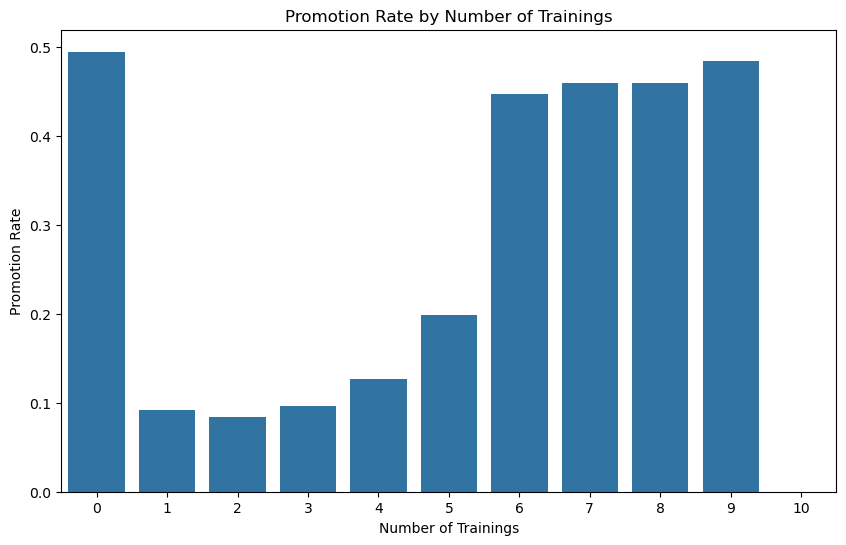

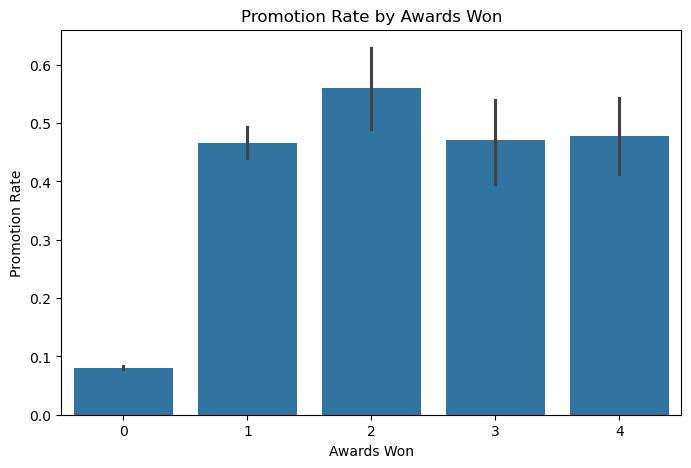

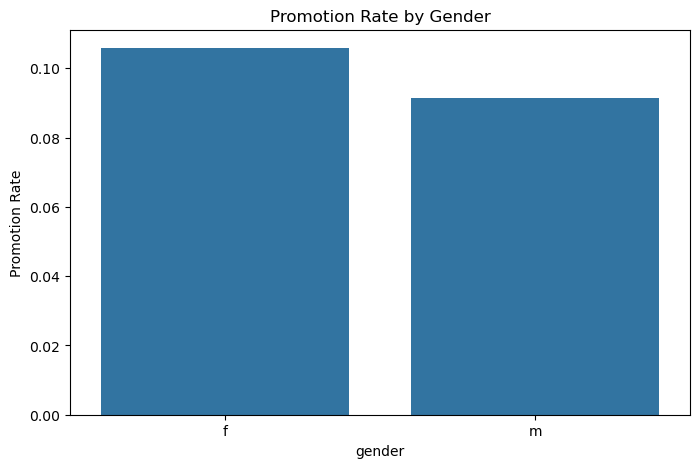

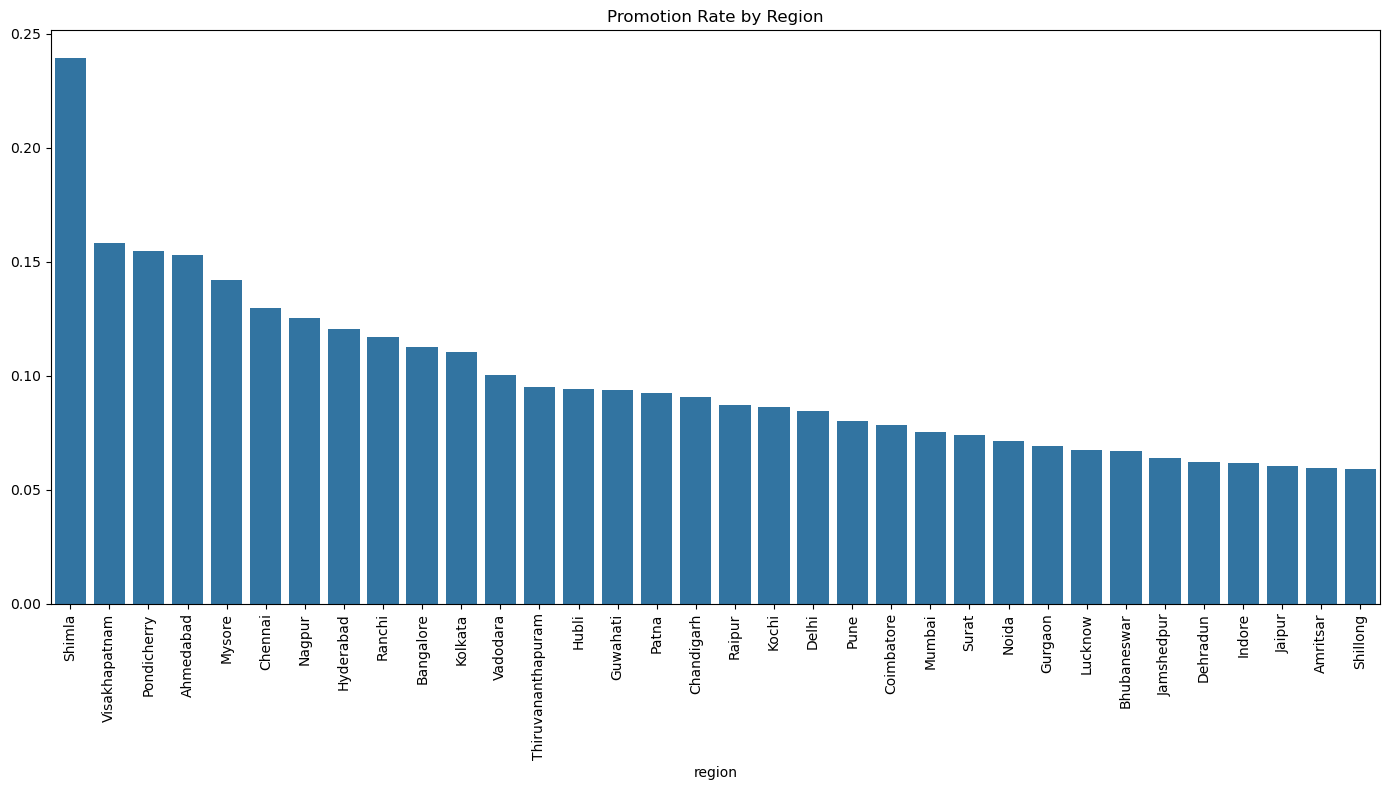

In [525]:
df_copy = df.copy()

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="avg_training_score", hue="is_promoted", kde=True, bins=20)
plt.title("Training Score Distribution by Promotion Status")
plt.xlabel("Average Training Score")
plt.show()

# Create bins for the training scores
bins = np.linspace(df["avg_training_score"].min(), df["avg_training_score"].max(), 10)
df_copy["training_score_bin"] = pd.cut(df["avg_training_score"], bins)

# Calculate promotion rate percentage for each bin
promotion_by_score = df_copy.groupby("training_score_bin")["is_promoted"].mean() * 100

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=promotion_by_score.index.astype(str), y=promotion_by_score.values)
plt.title("Promotion Rate by Training Score Range", fontsize=14)
plt.xlabel("Average Training Score Range", fontsize=12)
plt.ylabel("Promotion Rate (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Add percentage labels on top of each bar
for i, v in enumerate(promotion_by_score.values):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=10)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=df,
    x="length_of_service",
    y="age",
    hue="is_promoted",
    alpha=0.6,
    palette=["#FF9999", "#66B2FF"],
)
plt.title("Length of Service vs Age (Colored by Promotion Status)")
plt.show()


df_copy["previous_year_rating"] = pd.cut(
    df["length_of_service"],
    bins=[0, 1, 2, 3, 4, 5],
)
previous_year_rating = df_copy.groupby("previous_year_rating")["is_promoted"].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=previous_year_rating.index, y=previous_year_rating.values)
plt.title("Previous Year Rating Distribution by Promotion Status")
plt.xlabel("Previous Year Rating")
plt.show()

convert_to_string("education", df)
plt.figure(figsize=(12, 6))
edu_promotion = (
    df.groupby("education", observed=True)["is_promoted"]
    .mean()
    .sort_values(ascending=False)
)
sns.barplot(x=edu_promotion.index, y=edu_promotion.values)
plt.title("Promotion Rate by Education Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
convert_to_numeric("education", df)

plt.figure(figsize=(10, 6))
training_promotion = df.groupby("no_of_trainings")["is_promoted"].mean().reset_index()
sns.barplot(x="no_of_trainings", y="is_promoted", data=training_promotion)
plt.title("Promotion Rate by Number of Trainings")
plt.xlabel("Number of Trainings")
plt.ylabel("Promotion Rate")
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x="awards_won", y="is_promoted", data=df)
plt.title("Promotion Rate by Awards Won")
plt.xlabel("Awards Won")
plt.ylabel("Promotion Rate")
plt.show()

convert_to_string("gender", df)
plt.figure(figsize=(8, 5))
gender_promotion = df.groupby("gender")["is_promoted"].mean().reset_index()
sns.barplot(x="gender", y="is_promoted", data=gender_promotion)
plt.title("Promotion Rate by Gender")
plt.ylabel("Promotion Rate")
plt.show()
convert_to_numeric("gender", df)

convert_to_string("region", df)
plt.figure(figsize=(14, 8))
region_promotion = (
    df.groupby("region")["is_promoted"].mean().sort_values(ascending=False)
)
sns.barplot(x=region_promotion.index, y=region_promotion.values)
plt.title("Promotion Rate by Region")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
convert_to_numeric("region", df)

In [526]:
def remove_outliers_lof(df, columns, contamination=0.05):
    df_clean = df.copy()

    X = df_clean[columns].values

    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    y_pred = lof.fit_predict(X)

    outlier_scores = lof.negative_outlier_factor_

    df_clean = df_clean[y_pred == 1]

    print(f"Original data shape: {df.shape}")
    print(f"Clean data shape: {df_clean.shape}")
    print(
        f"Removed {df.shape[0] - df_clean.shape[0]} outliers ({((df.shape[0] - df_clean.shape[0])/df.shape[0])*100:.2f}%)"
    )

    return df_clean, outlier_scores


# # Example usage with numeric columns
# numeric_cols = [
#     "age",
#     "length_of_service",
#     "avg_training_score",
#     "no_of_trainings",
#     "previous_year_rating",
# ]
# df_no_outliers, outlier_scores = remove_outliers_lof(
#     df, numeric_cols, contamination=0.05
# )

# # You can also visualize the distribution of outlier scores
# plt.figure(figsize=(10, 6))
# plt.hist(outlier_scores, bins=50, alpha=0.7)
# plt.axvline(
#     x=np.percentile(outlier_scores, 5),
#     color="red",
#     linestyle="--",
#     label="5% threshold",
# )
# plt.title("Distribution of LOF Scores")
# plt.xlabel("Negative Outlier Factor (lower = more anomalous)")
# plt.ylabel("Count")
# plt.legend()
# plt.show()

Percentage of promotions among outliers vs non-outliers:
is_promoted         0         1
is_outlier                     
False        0.908244  0.091756
True         0.824499  0.175501


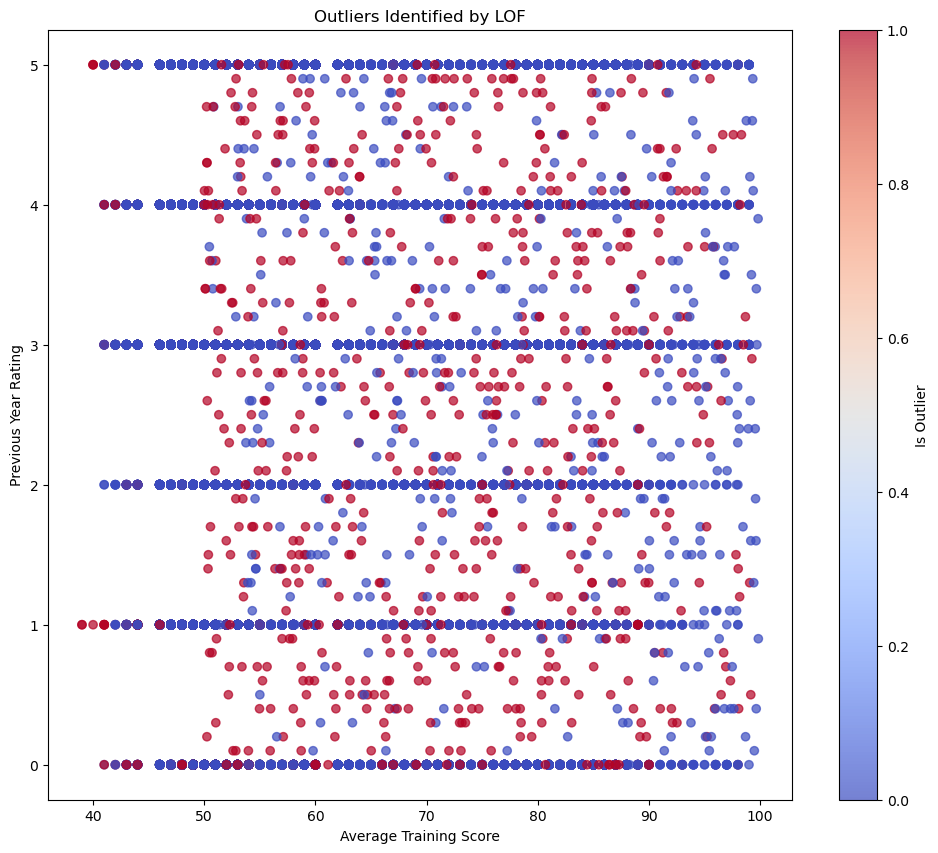

In [527]:
# Apply LOF but don't remove yet
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_predictions = lof.fit_predict(df[numeric_cols].values)
outlier_scores = lof.negative_outlier_factor_

# Add outlier information to dataframe
df_with_outliers = df.copy()
df_with_outliers["is_outlier"] = outlier_predictions == -1
df_with_outliers["outlier_score"] = outlier_scores

# Examine how outliers relate to promotions
promotion_outlier_table = pd.crosstab(
    df_with_outliers["is_outlier"], df_with_outliers["is_promoted"], normalize="index"
)
print("Percentage of promotions among outliers vs non-outliers:")
print(promotion_outlier_table)

# Visualize outliers vs non-outliers
plt.figure(figsize=(12, 10))
plt.scatter(
    df_with_outliers["avg_training_score"],
    df_with_outliers["previous_year_rating"],
    c=outlier_predictions == -1,
    cmap="coolwarm",
    alpha=0.7,
)
plt.colorbar(label="Is Outlier")
plt.xlabel("Average Training Score")
plt.ylabel("Previous Year Rating")
plt.title("Outliers Identified by LOF")
plt.show()

Characteristics of promoted non-outliers:


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted,outlier_score
count,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.000000,4440.0,4440.000000
mean,2.297297,9.205856,0.775225,0.670946,0.690541,1.269369,34.794820,3.678108,5.958333,0.198423,72.101212,1.0,-1.039020
std,2.156084,8.377496,0.687099,0.469923,0.763377,0.846103,7.366566,1.427847,4.155875,0.562833,14.709536,0.0,0.060694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,41.000000,1.0,-1.246809
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,30.000000,3.000000,3.000000,0.000000,59.000000,1.0,-1.069369
50%,2.000000,5.000000,1.000000,1.000000,1.000000,1.000000,33.000000,4.000000,5.000000,0.000000,72.000000,1.0,-1.022990
75%,4.000000,16.000000,1.000000,1.000000,1.000000,1.000000,38.000000,5.000000,8.000000,0.000000,84.000000,1.0,-0.997285
max,8.000000,33.000000,4.000000,1.000000,5.000000,9.000000,60.000000,5.000000,32.000000,4.000000,99.840000,1.0,-0.897461


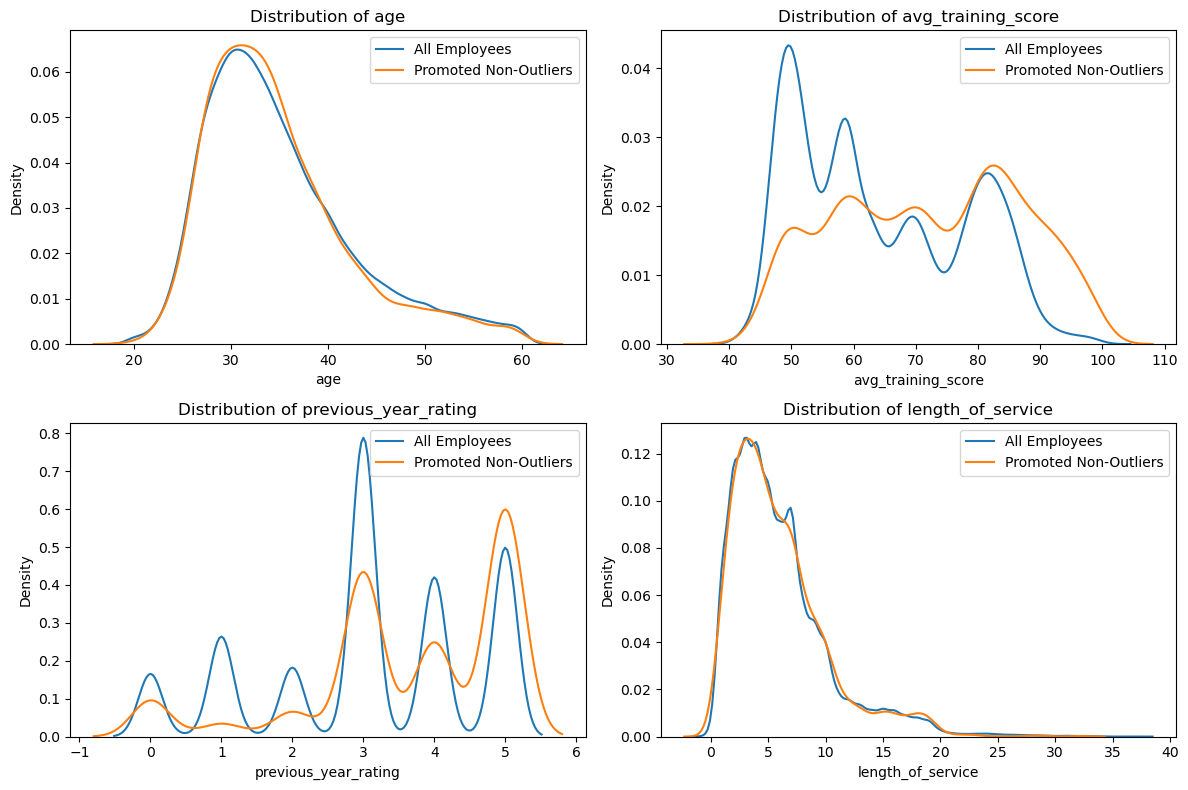

In [528]:
# Extract promoted non-outliers for analysis
promoted_non_outliers = df_with_outliers[
    (df_with_outliers["is_promoted"] == 1) & (df_with_outliers["is_outlier"] == False)
]

# Analyze their characteristics
print("Characteristics of promoted non-outliers:")
display(promoted_non_outliers.describe())

# Compare to all employees
plt.figure(figsize=(12, 8))
for i, col in enumerate(
    ["age", "avg_training_score", "previous_year_rating", "length_of_service"]
):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(df[col], label="All Employees")
    sns.kdeplot(promoted_non_outliers[col], label="Promoted Non-Outliers")
    plt.title(f"Distribution of {col}")
    plt.legend()
plt.tight_layout()
plt.show()

In [529]:
train, valid, test = np.split(
    df.sample(frac=1),
    [int(0.6 * len(df)), int(0.8 * len(df))],
)

train_samples = np.array_split(train, 10)
valid_samples = np.array_split(valid, 10)
test_samples = np.array_split(test, 5)

/home/diogo/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [530]:
def prepare_data(df, oversample=False):
    data = df[df.columns.difference(["is_promoted"]).difference(["region"])].values
    target = df["is_promoted"].values

    scaler = skpp.StandardScaler()
    data = scaler.fit_transform(data)

    if oversample:
        sm = imbp.RandomUnderSampler()
        data, target = sm.fit_resample(data, target)

    dataset = np.hstack((data, np.reshape(target, (-1, 1))))

    return dataset, data, target


def prepare_train_test_split(df):
    # Split data into outliers and non-outliers
    outliers = df[df["is_outlier"] == True].drop(
        ["is_outlier", "outlier_score"], axis=1
    )
    non_outliers = df[df["is_outlier"] == False].drop(
        ["is_outlier", "outlier_score"], axis=1
    )

    # Create training and test sets for each
    from sklearn.model_selection import train_test_split

    X_outlier = outliers.drop("is_promoted", axis=1)
    y_outlier = outliers["is_promoted"]
    X_regular = non_outliers.drop("is_promoted", axis=1)
    y_regular = non_outliers["is_promoted"]

    X_outlier_train, X_outlier_test, y_outlier_train, y_outlier_test = train_test_split(
        X_outlier, y_outlier, test_size=0.3, random_state=42
    )

    X_regular_train, X_regular_test, y_regular_train, y_regular_test = train_test_split(
        X_regular, y_regular, test_size=0.3, random_state=42
    )

    scaler = skpp.StandardScaler()
    X_regular_train = scaler.fit_transform(X_regular_train)
    X_regular_test = scaler.transform(X_regular_test)

    scaler_outlier = skpp.StandardScaler()
    X_outlier_train = scaler_outlier.fit_transform(X_outlier_train)
    X_outlier_test = scaler_outlier.transform(X_outlier_test)

    return (X_regular_train, X_regular_test, y_regular_train, y_regular_test), (
        X_outlier_train,
        X_outlier_test,
        y_outlier_train,
        y_outlier_test,
    )

In [531]:
#train, valid, test = train_samples[0], valid_samples[0], test_samples[0]

train, x_train, y_train = prepare_data(train)
valid, x_valid, y_valid = prepare_data(valid)
test, x_test, y_test = prepare_data(test)

(X_regular_train, X_regular_test, y_regular_train, y_regular_test), (
    X_outlier_train,
    X_outlier_test,
    y_outlier_train,
    y_outlier_test,
) = prepare_train_test_split(df_with_outliers)

print("Training set size:", len(x_train))
print("Validation set size:", len(x_valid))
print("Test set size:", len(x_test))
# Show proportion of promoted employees in the training target
print("Proportion of promoted employees in training set:", np.mean(y_regular_test == 1))

Training set size: 30561
Validation set size: 10187
Test set size: 10188
Proportion of promoted employees in training set: 0.09092787766067369


In [532]:
# # For Random Forest
# param_dist = {
#     'n_estimators': randint(50, 300),
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': randint(2, 20),
#     'min_samples_leaf': randint(1, 10),
#     'class_weight': ['balanced', 'balanced_subsample', None]
# }

# random_search = RandomizedSearchCV(
#     RandomForestClassifier(),
#     param_distributions=param_dist,
#     n_iter=20,
#     cv=5,
#     scoring='f1',
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )
# random_search.fit(X_regular_train, y_regular_train)
# print("Best parameters:", random_search.best_params_)
# print("Best score:", random_search.best_score_)

In [533]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.legend(loc="best")
    return plt




def plot_precision_recall_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        precision, recall, _ = precision_recall_curve(y_test, y_score)
        pr_auc = auc(recall, precision)

        plt.plot(recall, precision, lw=2, label=f"{name} (PR AUC = {pr_auc:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()


--- Decision Tree Results ---
Training time: 0.08 seconds
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      9175
           1       0.37      0.42      0.39      1013

    accuracy                           0.87     10188
   macro avg       0.65      0.67      0.66     10188
weighted avg       0.88      0.87      0.88     10188



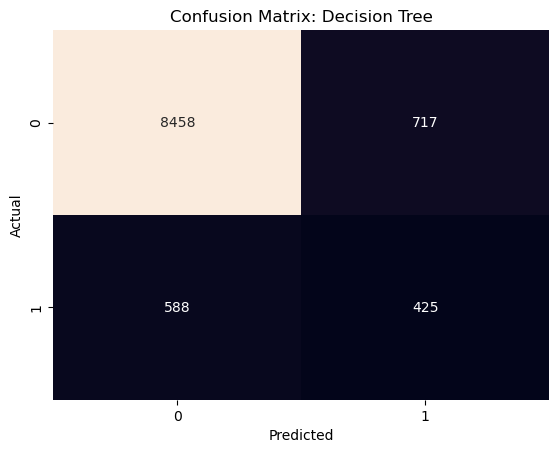


--- KNN Results ---
Training time: 0.81 seconds
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      9175
           1       0.65      0.18      0.29      1013

    accuracy                           0.91     10188
   macro avg       0.78      0.59      0.62     10188
weighted avg       0.89      0.91      0.89     10188



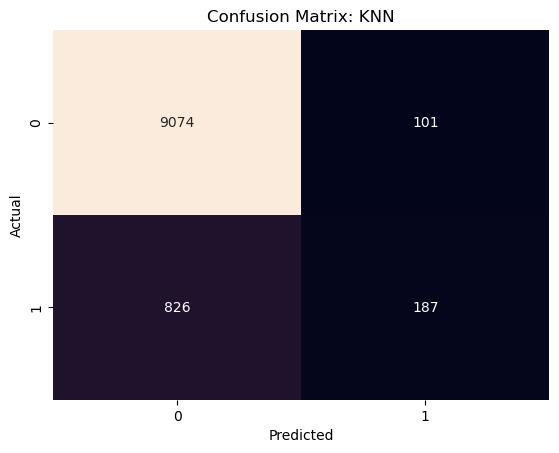


--- Random Forest Results ---
Training time: 6.45 seconds
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      9175
           1       0.52      0.51      0.52      1013

    accuracy                           0.90     10188
   macro avg       0.73      0.73      0.73     10188
weighted avg       0.90      0.90      0.90     10188



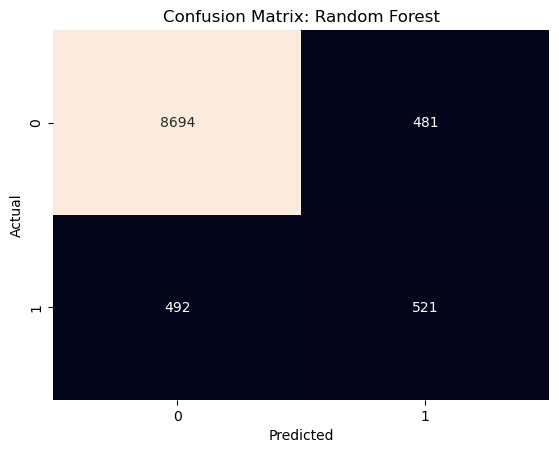


--- Gradient Boosting Results ---
Training time: 1.42 seconds
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9175
           1       0.82      0.29      0.43      1013

    accuracy                           0.92     10188
   macro avg       0.87      0.64      0.70     10188
weighted avg       0.92      0.92      0.91     10188



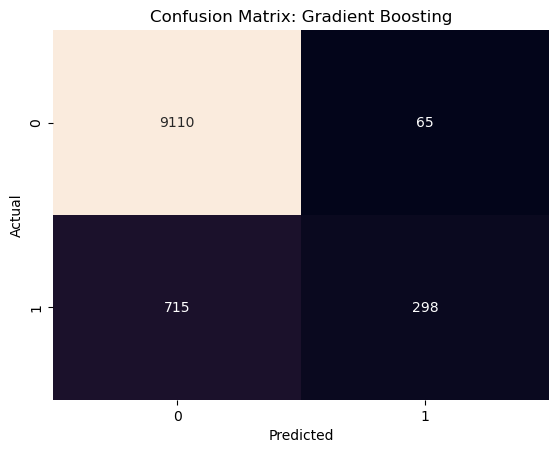


--- Logistic Regression Results ---
Training time: 0.02 seconds
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9175
           1       0.63      0.07      0.13      1013

    accuracy                           0.90     10188
   macro avg       0.77      0.53      0.54     10188
weighted avg       0.88      0.90      0.87     10188



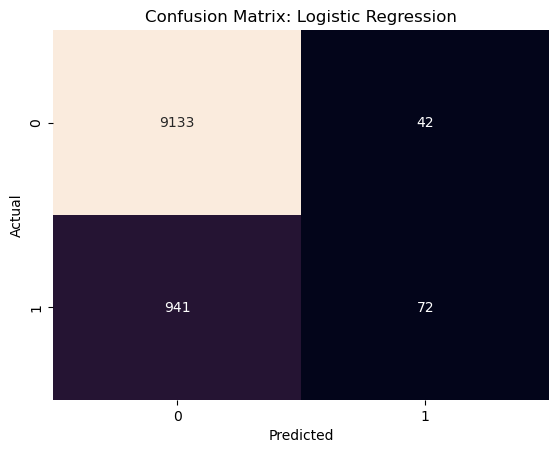


--- Neural Network Results ---
Training time: 8.48 seconds
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9175
           1       0.80      0.35      0.49      1013

    accuracy                           0.93     10188
   macro avg       0.87      0.67      0.73     10188
weighted avg       0.92      0.93      0.91     10188



/home/diogo/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


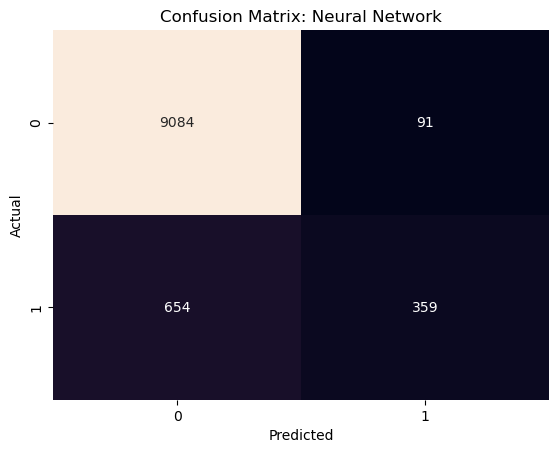

In [534]:
models = {
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
    ),
    "KNN": skkn.KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced_subsample",
        max_depth=40,
        min_samples_leaf=2,
        min_samples_split=13,
        n_estimators=211,
    ),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Neural Network": MLPClassifier(),
}

# for x_train, x_test, y_train, y_test in [
#     (X_regular_train, X_regular_test, y_regular_train, y_regular_test),
#     (X_outlier_train, X_outlier_test, y_outlier_train, y_outlier_test),
# ]:
#     for name, model in models.items():
#         startTime = time.time()
#         fitted_model = model.fit(x_train, y_train)
#         pred = model.predict(x_test)
#         endTime = time.time()
#         print(f"\n--- {name} Results ---")
#         print(f"Training time: {endTime - startTime:.2f} seconds")
#         print(skmt.classification_report(y_test, pred))

#         # plot_learning_curve(model, f"Learning Curve for {name}", X_regular_train, y_regular_train, cv=5, n_jobs=-1)
#         # plt.show()

#         cm = confusion_matrix(y_test, pred)
#         sns.heatmap(cm, annot=True, fmt="d", cbar=False)
#         plt.title(f"Confusion Matrix: {name}")
#         plt.ylabel("Actual")
#         plt.xlabel("Predicted")
#         plt.show()
        
for name, model in models.items():
    startTime = time.time()
    fitted_model = model.fit(x_train, y_train)
    pred = model.predict(x_test)
    endTime = time.time()
    print(f"\n--- {name} Results ---")
    print(f"Training time: {endTime - startTime:.2f} seconds")
    print(skmt.classification_report(y_test, pred))

    # plot_learning_curve(model, f"Learning Curve for {name}", X_regular_train, y_regular_train, cv=5, n_jobs=-1)
    # plt.show()

    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Confusion Matrix: {name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
# Get prediction probabilities

/home/diogo/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


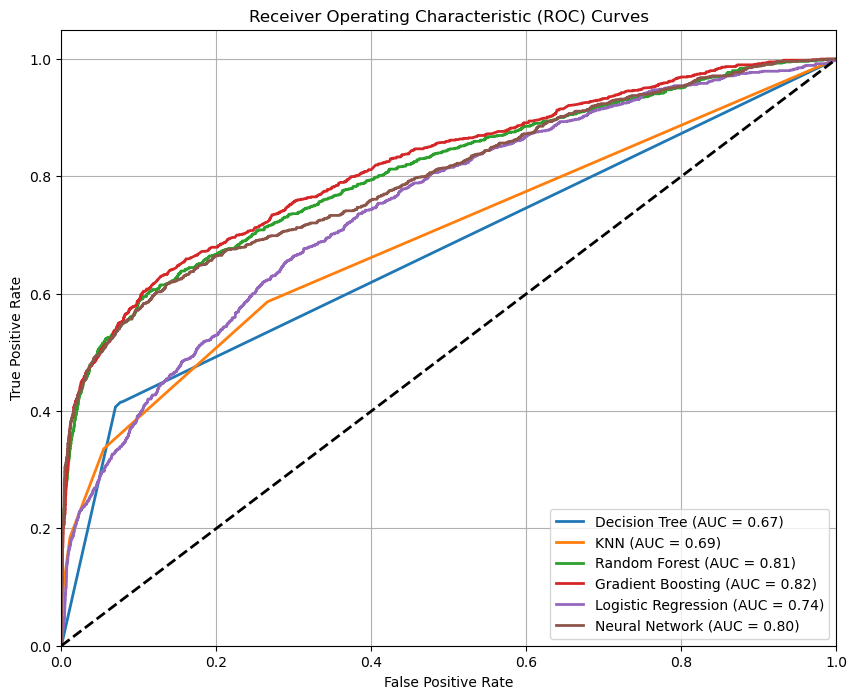

In [535]:
# Function to plot ROC curves for all models
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# Call the function for your trained models
# models_fitted = {}
# for name, model in models.items():
#     model.fit(X_regular_train, y_regular_train)
#     models_fitted[name] = model

# plot_roc_curves(models_fitted, X_regular_test, y_regular_test)

# models_fitted = {}
# for name, model in models.items():
#     model.fit(X_outlier_train, y_outlier_train)
#     models_fitted[name] = model

# plot_roc_curves(models_fitted, X_regular_test, y_regular_test)

models_fitted = {}
for name, model in models.items():
    model.fit(x_train, y_train)
    models_fitted[name] = model

plot_roc_curves(models_fitted, x_test, y_test)

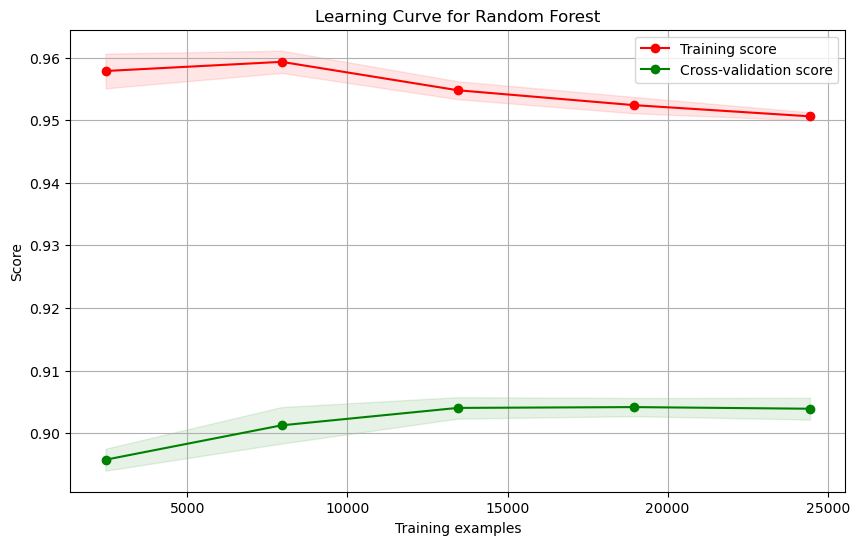

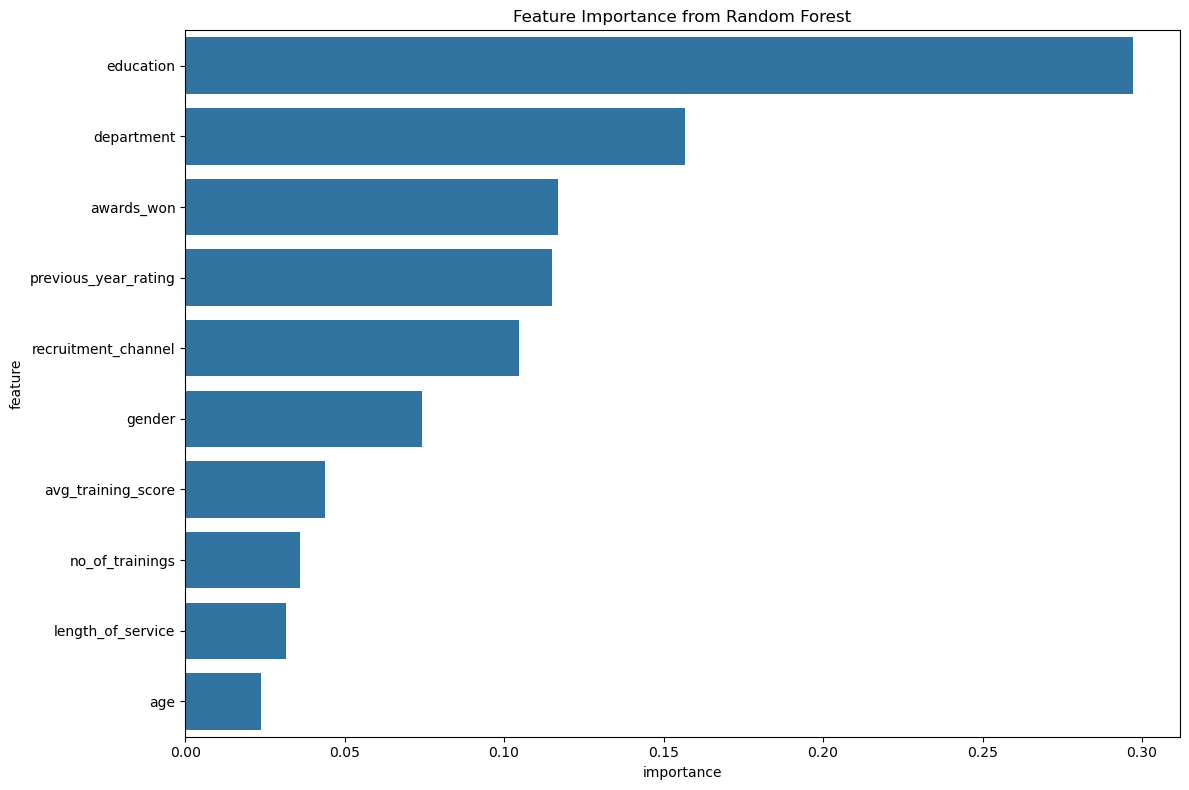

In [537]:
# For Random Forest
rf_model = models["Random Forest"]
rf_model.fit(x_train, y_train)

plot_learning_curve(
    rf_model,
    f"Learning Curve for Random Forest",
    x_train,
    y_train,
    cv=5,
    n_jobs=-1,
)
plt.show()

# Get feature importance
feature_names = df.drop(
    ["is_promoted", "region"], axis=1
).columns
feature_importances = pd.DataFrame(
    {"feature": feature_names, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=feature_importances)
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()